In [ ]:
%load_ext autoreload


In [ ]:
%autoreload 2


In [ ]:
%matplotlib inline


In [ ]:
from pathlib import Path

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np


In [ ]:
!pip install geopandas


     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 15.4 MB 30.0 MB/s 
     |████████████████████████████████| 6.3 MB 43.1 MB/s 


In [ ]:
import geopandas as gpd


In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
import rasterio


In [ ]:
import shapely


In [ ]:
from pprint import pprint


In [ ]:
!pip install utils

In [ ]:
import utils


In [ ]:
import sys

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
sys.path.insert(0, '/usr/local/lib/python3.7/dist-packages/utils')

In [ ]:
sys.path.insert(0, '/usr/local/lib/python3.7/dist-packages/utils/data')

In [ ]:
from utils.other import new_pickle, load_pickle, new_json, load_json


In [ ]:
inpath_s2 = Path(r'/usr/local/lib/python3.7/dist-packages/utils/data/RGB_small.tif')
inpath_fields = Path(r'/usr/local/lib/python3.7/dist-packages/utils/data/marker2016_small.shp')

outpath = Path(r'/content/output\preprocessed')

In [ ]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .pipe(utils.geo.explode_mp)
             .pipe(utils.geo.buffer_zero)
             .pipe(utils.geo.close_holes)
             .pipe(utils.geo.set_crs, 3044)
             .to_crs(out_crs)
             .pipe(utils.geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True)
             .pipe(utils.geo.reclassify_col, rcl_scheme=utils.geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True)
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(utils.geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(utils.geo.reduce_precision, precision=4)
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 'area_sqm', 'fid', 'geometry']))
    return df

outpath_fields = outpath / 'prepared_vector.shp'

if not outpath_fields.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(inpath_fields, raster_meta['crs'], raster_bounds)
    outpath_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(outpath_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting shp file... {outpath_fields.name}')
    df = gpd.read_file(str(outpath_fields), encoding='cp865')
     
print(df.info())
display(df.head(3))

/usr/local/lib/python3.7/dist-packages/utils/geo.py:67: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  df_temp = df_temp.append([row] * len(row.geometry), ignore_index=True)
/usr/local/lib/python3.7/dist-packages/utils/geo.py:68: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for i in range(len(row.geometry)):
/usr/local/lib/python3.7/dist-packages/utils/geo.py:69: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  df_temp.loc[i, 'geometry'] = row.geometry[i]
/usr/local/lib/python3.7/dist-packages/utils/geo.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   journalnr  234 non-null    object  
 1   lc_id      234 non-null    object  
 2   lc_name    234 non-null    object  
 3   r_lc_id    234 non-null    int64   
 4   r_lc_name  234 non-null    object  
 5   area_sqm   234 non-null    float64 
 6   fid        234 non-null    int64   
 7   geometry   234 non-null    geometry
dtypes: float64(1), geometry(1), int64(2), object(4)
memory usage: 14.8+ KB
None


,journalnr,lc_id,lc_name,r_lc_id,r_lc_name,area_sqm,fid,geometry
0,16-0020644,1,Vσrbyg,1,springcereal,6815.901431,0,"POLYGON ((516595.967 6243188.344, 516653.117 6..."
1,16-0036135,11,Vinterhvede,2,wintercereal,15477.545517,1,"POLYGON ((514192.096 6243546.014, 514159.409 6..."
2,16-0014547,280,Fodersukkerroer,5,other,54178.844742,2,"POLYGON ((515447.501 6243668.219, 515629.140 6..."


In [ ]:
outpath_chips = outpath / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not outpath_chips.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
    chip_dfs = utils.geo.cut_chip_geometries(vector_df=df,
                                             raster_width=raster_meta['width'],
                                             raster_height=raster_meta['height'],
                                             raster_transform=raster_meta['transform'],
                                             chip_width=chip_width,
                                             chip_height=chip_height,
                                             first_n_chips = 1000)
    new_pickle(outpath_chips, chip_dfs)
else:
    chip_dfs = load_pickle(outpath_chips)
    
print('len', len(chip_dfs))

9it [00:00, 44.35it/s]

Writing new pickle file... chip_dfs.pkl
len 9


In [ ]:
train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(chip_dfs, test_size=0.2, seed=1)
coco_train = utils.coco.format_coco(train_chip_dfs, chip_width, chip_height)
coco_val = utils.coco.format_coco(val_chip_dfs, chip_width, chip_height)
new_json(outpath / r'annotations\train2016.json', coco_train)
new_json(outpath / r'annotations\val2016.json', coco_val)

Writing new json file... annotations\train2016.json
Writing new json file... annotations\val2016.json


In [ ]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = utils.img.cut_chip_images(inpath_raster=inpath_s2,
                                            outpath_chipfolder=outpath / r'images\train2016', 
                                            chip_names=chip_windows.keys(),
                                            chip_windows=chip_windows.values(), 
                                            bands=[3, 2, 1])

utils.coco.move_coco_val_images(inpath_train_folder=outpath / r'images\train2016',
                                val_chips_list=val_chip_dfs.keys())

print('len', len(chip_statistics))

9it [00:00, 121.90it/s]

len 9


In [ ]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))}

new_json(outpath / 'statistics.json', statistics)
pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 28.0,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 252,
 'nr_polys_train': 192,
 'nr_polys_val': 60,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


Loading from existing json file... annotations\val2016.json
COCO_val2016_000000100005.jpg


/usr/local/lib/python3.7/dist-packages/utils/coco.py:189: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  patches = [PolygonPatch(p, ec='r', fill=False, alpha=1, lw=0.7, zorder=1) for p in mp]
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


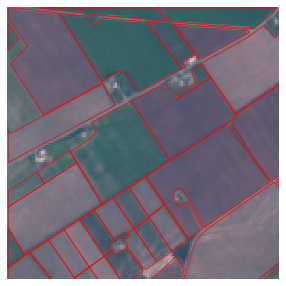

COCO_val2016_000000100006.jpg


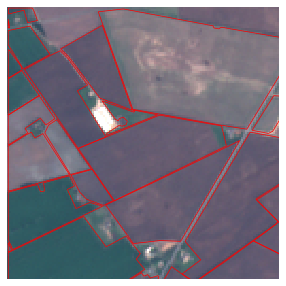

In [ ]:
utils.coco.plot_coco(inpath_json=outpath / r'annotations\val2016.json', 
                     inpath_image_folder=outpath / r'val2016', 
                     end=2)
